<a href="https://colab.research.google.com/github/RK900/cs182_project/blob/main/GPT_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




## Instructions

- Change root folder to path to cwd so that imports work fine, this is also the directory where the yelp data is stored
- Skip colab cell if running locally

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
root_folder = "/content/drive/My Drive/cs182_project/"

In [3]:
import sys

In [4]:
sys.path.append(root_folder)

This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch. 
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [5]:
!pip install transformers

In [6]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!nvidia-smi

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [8]:
from data_parsing import load_dataset
json_dir = os.path.join(root_folder, "yelp_review_training_dataset.jsonl")
data = load_dataset(json_dir)

In [9]:
reviews234 = [i for i in data if i[1] == 2 or i[1] == 3 or i[1] == 4]

In [29]:
split_idx = int(len(reviews234) * 0.8)
train, val = reviews234[:split_idx], reviews234[split_idx:]

In [30]:
t = train[2][0].replace('\n', "").replace('\t', "")
t

'I was really looking forward to visiting after having some of their beers. The "Man O\'War" quickly became my favorite DIPA; the Rusulka Vanilla Stout is a good thick, sweet stout; and the Ironclad is a top notch IPA. The only big miss on their beers I\'ve had is the Big Chuck Barleywine. It could probably benefit greatly with age, but at this age all there is to taste is the alcohol.  Nonetheless, I had enough to convince me that the other beers I hadn\'t had from them would be top notch... and they are! The reason for the 2 stars should not reflect the quality of the brewers, they obviously know their craft well! The servers are great and friendly.... but relying on two servers to wait on 100+ customers says a lot about how inexperienced management must be. In fact, after waiting 15 mins at a dirty table I was finally able to track down someone I guessed was an employee to let them know we were even there! After another 5+ mins, the GM finally stopped over to take our drink order. T

In [31]:
train[2][1]

2.0

In [39]:
for i in train:
  assert i[1] == 2 or i[1] == 3 or i[1] == 4

In [40]:
for i in val:
  assert i[1] == 2 or i[1] == 3 or i[1] == 4

In [42]:
with open(os.path.join(root_folder, "yelp_review_training_dataset_234.csv"), 'w') as f:
    f.write("text\n")
    for pair in train:
        f.write("" + pair[0].replace('\n', "").replace('\t', "") + "\n")
with open(os.path.join(root_folder, "yelp_review_training_dataset_234_labels.csv"), 'w') as f:
    f.write("text\n")
    for pair in train:
        f.write(str(pair[1]) + "\n")

In [43]:
with open(os.path.join(root_folder, "yelp_review_val_dataset_234.csv"), 'w') as f:
    f.write("text\n")
    for pair in val:
        f.write("" + pair[0].replace('\n', "").replace('\t', "") + "\n")
with open(os.path.join(root_folder, "yelp_review_val_dataset_234_labels.csv"), 'w') as f:
    f.write("text\n")
    for pair in val:
        f.write(str(pair[1]) + "\n")

In [44]:
# # copy the data to the current Colab working directory
# !cp $data_dir/$filename .

In [7]:
# mount my Google Drive directory and access the training data located there
data_dir = os.path.join(root_folder, "yelp_review_training_dataset_234.csv")
# filename = 'yelp_review_training_dataset.csv'

# drive.mount(gdrive_dir, force_remount=True)


In [8]:
# load into a data frame
print(data_dir)
df = pd.read_csv(data_dir, error_bad_lines=False, sep='\t', header='infer', lineterminator='\n')  
print(df)

/content/drive/My Drive/cs182_project/yelp_review_training_dataset_234.csv
                                                     text
0       I'll be the first to admit that I was not exci...
1       Tracy dessert had a big name in Hong Kong and ...
2       I was really looking forward to visiting after...
3       It's a giant Best Buy with 66 registers.  I do...
4       Like walking back in time, every Saturday morn...
...                                                   ...
113987  The ambiance is sophisticated and upscale. Exa...
113988  ** 2.5 **The food is.....okay, to say the leas...
113989  This place was definitely a nice break from th...
113990  For my birthday i decided to get my industrial...
113991  I have liked this car wash for 5 years . Howev...

[113992 rows x 1 columns]


In [9]:
df.dropna(inplace=True) #remove NA values
bios = df.text.copy() #just use the main bio text in this example
bios

0         I'll be the first to admit that I was not exci...
1         Tracy dessert had a big name in Hong Kong and ...
2         I was really looking forward to visiting after...
3         It's a giant Best Buy with 66 registers.  I do...
4         Like walking back in time, every Saturday morn...
                                ...                        
113987    The ambiance is sophisticated and upscale. Exa...
113988    ** 2.5 **The food is.....okay, to say the leas...
113989    This place was definitely a nice break from th...
113990    For my birthday i decided to get my industrial...
113991    I have liked this car wash for 5 years . Howev...
Name: text, Length: 113992, dtype: object

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

## Can skip this cell, takes unnecessarily long

In [11]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

KeyboardInterrupt: ignored

In [64]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.003412520176854516

In [65]:
np.average(doc_lengths)

124.56185521791002

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [10]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [11]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [12]:
batch_size = 32

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [13]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="distilgpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [14]:
dataset = GPT2Dataset(bios[:int(len(bios))], tokenizer, max_length=128)

In [15]:
len(dataset)

113992

In [16]:
# Split into training and validation sets
train_size = int(0.9 * len(dataset))
# val_size = int(0.5 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

102,592 training samples
11,400 validation samples


In [17]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [18]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [19]:
# some parameters I cooked up that work reasonably well

epochs = 3
learning_rate = 1e-2
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [20]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [21]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [22]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [23]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,206. Loss: 3.3198490142822266.   Elapsed: 0:01:46.
0:  bipartisanHorrible service. We tried to return back to get rid of our order while we were waiting on a ride home from my work, and I requested a different store from the office for my next visit. The prices are pretty steep, and prices are much higher than their average in the past.The service is friendly.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,206. Loss: 4.585556983947754.   Elapsed: 0:03:39.
0:  increasingaiso a best, for $ bar so you feel to a a day but they is a great. She't the table and a little my location with a few with a waitress for an bit place that was have so  I have the chicken with a friend the same stars to not a food, for the best, I don't very friendly of the waitress. She and it are some table. Also in not nice with a little my place is good, I were looking for a wait, the best in the few meal.  There is sure to the friend and the best to the day as you would have my food.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,206. Loss: 3.620086193084717.   Elapsed: 0:05:36.
0: dayNot bad place to be more time in a week and what they recommend the service was very ok. 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,206. Loss: 3.725560426712036.   Elapsed: 0:07:32.
0:  Hangーなで�で�なで�でき��なー��な�ででで。す。す�はいで�は���ー。なででなー。�いでででで�りき�な。でですす�はななはす�でなす。�で��で�ーでででで�は�な。で。ーでーーではいでな�すははでで��は��す��は�でで�でで�で�でい。いで��ででいではで�でででででい���でなで���な���ではい。��すは��で�なないはいはではい�いはで��ででななで��で�はでなででなでい�


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,206. Loss: 3.9602630138397217.   Elapsed: 0:09:30.
0:  foodsIt would have an obvious time of coming to have my work in a different place to shop on a good deal, but not very flexible.I really like this's one of the items.  My son and I like the best items to get to get from the store and when we were looking for the new products, it's very much to have a a real selection on the shelf when I came by my friend for us.  And the menu, they can have better people, and some people working here at a very soon though, there are on a great time.  If you want to come in the store or you want a coffee, their own time needs to get the sandwiches from a good and other friends to pick out from my glasses from a little out a quarter back on items and they will be to a hard.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,206. Loss: 3.3533313274383545.   Elapsed: 0:11:28.
0:  trailMy sister went in to play a few years ago. My sister loves this place and wanted to play a few weeks before we started home.  We arrived late and grabbed our drinks/chairs and ordered the salad.  The order included the pork, pork, and bacon.  My sister ordered the shrimp (for 15 minutes).  In addition the sandwich was very tasty and came along with good cheese.  Great sandwiches and other toppings.  And very good service.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,206. Loss: 2.926166296005249.   Elapsed: 0:13:26.
0: intendDisappointing. Had the chicken bowl. Food was good and there was not much flavour. Not for happy hour, but it was good for lunch. Never, but not worth my time.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,206. Loss: 3.0367918014526367.   Elapsed: 0:15:23.
0:  surroundI was at the store recently looking for a nice pair of glasses. I walked in there while the employee ringing my head out. As soon as I walked in I thought she was out to talk with me and my eyebrows was not blown away.I walked in and it was not busy for me. It was obvious they didn't have a busy shop and this isn't the most fun shopping location I've ever been.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,206. Loss: 3.0364720821380615.   Elapsed: 0:17:20.
0:  reflexIf you're coming in, the employees are friendly but, maybe they're just too lazy.  When the rest of the customers are lazy, you can tell the person working there is no employee in line for long periods of time.   The service is pretty standard slow as hell.  Service can't be better than to say that...it's good food.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,206. Loss: 3.0501604080200195.   Elapsed: 0:19:18.
0:  displayI've been a patient here for a year and always had good results.  The staff is friendly and accommodating.  Overall the place is great and a great spot to relax and enjoy some sort of coffee.  I love that there is so much different varieties that the food is very consistent and consistent.  The place is good in a quiet center between 5 or 6.  It's not very busy when the place gets busy. 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,206. Loss: 2.6393930912017822.   Elapsed: 0:21:16.
0:  pastorThe guy at the bar who was very nice and was very helpful in making me feel comfortable after my first visit to the bar was pretty good the service was quick service was a little slow but not too late the waitress I had the best service we could ever experienced in Las Vegas I would come back and try again


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,206. Loss: 3.0830485820770264.   Elapsed: 0:23:12.
0:  illicitI hate it, the kids have like 3 carts and it's too expensive for adults. I have seen different things in their store from different types to more.  Know to pay $20 to pay $40 and it's all the same price for a child. The store isn't good. You are likely just getting a loan from them for $5 and you'll leave every store.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,206. Loss: 2.933929204940796.   Elapsed: 0:25:10.
0:  LiberationWe stopped in after a long long weekend breakfast. It was busy, clean, and the coffee was very good. I liked how the coffee was hot, but I'm a huge fan of the coffee bar as there's a bar area. The coffee was good, the prices were reasonable, and the place was very spacious. We ordered a big ham croissants, both were very sweet, and the coffee was delicious. The coffee was good, but was a bit pricy for a latte place. I had a latte and a latte and they were very friendly but they were pricey for something like that. The latte took a bit longer than I expected, but it was also tasted fresh. The coffee was delicious. It's a coffee shop not much bigger than what I liked, and you can get from a bakery that. The coffee shop at a coffee spot. I guess the Kensington Market Street cafe in Kensington Market Square St.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,206. Loss: 2.791639566421509.   Elapsed: 0:27:08.
0:  NamCute and quiet atmosphere with plenty of tables and the food was awesome. The service was very good and everyone seemed nice, polite and friendly.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,206. Loss: 2.719183921813965.   Elapsed: 0:29:05.
0: IONPork: Nachos with guacamole: guacamole: guacamole: guacamole: guacamole de galleria guacamole = guacamole de galles en galles: guacapenos en guacamón guacamón : emacacipole. Jalacacamole: guacip, el Carnomacamón, tacos and guacamole-tostico-cafe de guacamole: a Carnacamole: El Cortez en chorizo de empanadas! Le Pico-Vada: El Cortez Ciachoses, El Cortez de El Cortez n'empo-cées n'est arrivemil guacamón, à les ses ou vins au nachos. Envy semsés de jambre les frites à emporter et en nach


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,206. Loss: 3.014831781387329.   Elapsed: 0:31:04.
0:  glimpseGood music. Great people watching. No problem but there are lots of rooms to bring your own drinks. I would definitely recommend it


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,206. Loss: 2.503225088119507.   Elapsed: 0:33:01.
0:  LaureWas impressed that our server was on time. The restaurant has a variety of different types of sandwiches, and it's always been my favorite for us, and we have never had a problem with it at our table. My boyfriend was a friend of mine for the last time. The restaurant was open about a week ago, and he was very helpful. He has a wonderful experience with the food choices and the service is wonderful. This is my first visit since we had no longer in town, and we've always been a fan of their sandwiches and salads. They have a great sandwich options here on the menu and every time we order I'm not impressed with the time that you order. We tried the deluxe pepperonis, but it was like my wife's delicious.  the sauce and the pepperonis. We asked if we usually have a little salt. We usually try a bit. The taste of salt was delicious, and tangy. Our waiter for extra salt and tangy, and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,206. Loss: 2.9094910621643066.   Elapsed: 0:34:59.
0: ismWe were disappointed to stumble into this restaurant. We decided to take a few of our children to take our kids around. The kids in the kitchen were super friendly, friendly and eager to see us when we got our kids ready. We were excited to come in for a quick takeout food and the kids menu was great. I had a large chicken wrap which was perfectly balanced. The only reason we will not be coming back is because we were closed for a long time. Unfortunately, the kids menu is very good, however, we also found it to be more of a "look at everything" but it was not good!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,206. Loss: 2.9721481800079346.   Elapsed: 0:36:58.
0: ounThis location is a small gem. It's located beside some stores (I really like stores).  It's the perfect place to get some drinks!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,206. Loss: 2.8440186977386475.   Elapsed: 0:38:55.
0:  electionThe staff was super friendly and the facility is great. They are very clean and my husband and I always get our appointments. They had a ton of equipment and were very reasonable but the service was terrible. She didn't seem to understand anything and they did not say a word or anything to us at all, and told us that the next two technicians would not make me clean if they hadn't done a better cleaning. We also paid an hour and half before leaving with our food and it took another 30 minutes for the check to arrive, then the guy told us it would be a total waste.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,206. Loss: 2.73738694190979.   Elapsed: 0:40:54.
0:  crazyReally nice guy who really knows everything about his craft.  I would have liked to see him for my birthday.  Was an alright experience at this local local pub.  There was the same crowd from the other people there.  They had TVs playing playing a football at the bar but it could have been silly to watch all the TV people there.  There were several that walked in and the bartender was quite rude at first and had to do so.  My wife ordered a side of chicken fingers and was quite satisfied.  We ordered the wings.  It's a little too oily but not bad.  Maybe not really as good as the fried fries I do at their places.  Overall, if this is a better then I won't go to have some sort of a great atmosphere then you are better places.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,206. Loss: 2.7605597972869873.   Elapsed: 0:42:52.
0:  benchThis place is the best part here. Staff is friendly, and the food is cheap.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,206. Loss: 3.0049173831939697.   Elapsed: 0:44:49.
0:  incorporatedIf you're a local, I'll have to go somewhere else.   We used to come here for my daughters birthday and the server was so sweet!  He just didn't push on my cousin, or if we needed something that we wanted, he just didn't listen to how I asked for it.  We were both disappointed and a couple of months later he showed up and looked at us on their phone.  We were so unhappy with the guy...and a couple months later we got off...after speaking about we had to do it with her for the last 7 months, which we thought seemed a little strange to me.  He didn't really help with the whole thing, she was really wasn't even trying to give me, and I had to get me a great.   never asked for any explanation and just didn't even asked for help.  and just had it was just wasn't even asked what we had a good.  he wouldn't want and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,206. Loss: 2.8471274375915527.   Elapsed: 0:46:48.
0: PeterI've been to this store every time with my mom. While there are not that many selection available, they still have great inventory (and not bad). The store is relatively inexpensive and the store has a vast selection.The other people there have great help and were friendly and help. The selection was fairly similar to it before it was in my book. The store has a fairly cool collection of records and books. And I was really impressed with the variety and character of the place. There is also one more thing that is great about the store. It was nice to get the gift with a bottle of wine from the store and get it. I'm sure that's what they say but their prices are ridiculous and not very friendly.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,206. Loss: 2.4393832683563232.   Elapsed: 0:48:46.
0: uringWe had to be honest that we couldn't find out when we were there on a Sunday morning and the prices were more than fair. I will say some of my time I went in today for some drinks and the drinks were pretty cheap. I thought we were walking through a strip of Highway 7. I asked about how the best drink I had ever had (or that they said that they are pretty weak) and they pointed out that they are very busy as I thought it was worth the wait.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,206. Loss: 2.985197067260742.   Elapsed: 0:50:44.
0:  reproductiveCame in for an oil change at 9 am. Not an actual drive but this is an oil change and my oil change was no. It wasn't bad but it wasn't a bad one...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,206. Loss: 3.0204367637634277.   Elapsed: 0:52:41.
0:  zoneI used to run this location before the week when they opened the new location. I stopped in the store because I was a fan of the new location, but today is where they changed their menu. The menu is not the same as the new location, so I decided to give them a try today.The service was very nice, it wasn't busy enough for me. The waitress gave me the right type of sushi. She made the sushi list, it looked like everything was frozen. She didn't mind me when she came by with my hair and took her orders. It was a mistake to try, but I definitely think I'll probably go back again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,206. Loss: 2.6893723011016846.   Elapsed: 0:54:39.
0:  commitsI came here with my family. We came to this place on our Saturday night in hopes of a good deal. The restaurant is a little crowded on a Monday night and was very busy. We went with our family and were seated on time and everything was great. Our server was awesome and our order was ready and promptly delivered. Our food came hot (we weren't expecting hot sauces but when we ordered the food we didn't know it was). We were sat at a table. My husband had the pulled pork that was delicious. The sauce was delicious and the dressing was so nice. We were told that our entrees were ready and the server would call back to bring us back the next day to check if we were available for drinks as our entrees. We weren't having a glass of coffee. The wine. We were given the menu, our entrees we decided to bring our bill, our first thing to order and our meal at the next day a manager was quickly to get


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,206. Loss: 2.7857930660247803.   Elapsed: 0:56:38.
0:  ironyI just returned to the area and was really looking forward to eating here, as I am still getting a "good" Mexican menu from the outside of the dining room.  The tacos, as well, were very good.  We are looking forward to trying their tacos again.  Great deal, with the most expensive taco place around the world.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,206. Loss: 2.8966422080993652.   Elapsed: 0:58:36.
0:  SahFirst time in years. Food was tasty, service was great and it took a few bites.  We ordered the stuffed fish and chips, guacamole, and a grilled calamari. We decided to go back again for it, not as much as they were advertised.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,206. Loss: 2.69858455657959.   Elapsed: 1:00:33.
0:  BryanThe Distillery is a very nice example of what it is in. We were able to purchase a pair of furniture for our anniversary. We both decided to purchase and search the nearest one with our wedding. The sales person (not only do one) was extremely kind and helpful. After finding out that the prices for the next item were competitively higher I'd rather make another purchase. We also went with the two other sales representatives, who had not found some of us. She was able to explain everything on the website, and did not write an agreement or discussion a bad review. We were the ONLY ones in the store, so I'd give it a try, but you a chance to give this one of finding one. We will make another one. They will get a great customer experience if you an amazing experience.!!!!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,206. Loss: 2.98052978515625.   Elapsed: 1:02:31.
0:  spiritsGot our glasses to go. Got the shrimp cocktail and the poutine. Both of my friends enjoyed the pierogi platter. They were really busy in there at 11 pm and we got the chicken wings. Both were excellent. However the garlic knots were a bit on the salty side. However overall good experience for a quick food dinner.

  Average training loss: 3.13
  Training epoch took: 1:02:39

Running Validation...
  Validation Loss: 2.75
  Validation took: 0:02:24

======== Epoch 2 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,206. Loss: 2.7475109100341797.   Elapsed: 0:01:57.
0:  seesI got my hair done 2/2014, but I can't say anything about it.  When they called me back, they were about to get me through and out of the chair which was frustrating when the first time I was done I was taken aback.  The second time it was my haircut, the third time I received the haircut and half way through, my hair was still still completely gone!  All the other things aside were fine.   I would go back, and would be happy about the service and style.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,206. Loss: 2.639827251434326.   Elapsed: 0:03:54.
0:  hungryI've been to a couple different locations as well. In particular, one was very professional and clean. The staff is really friendly but my husband found something he was a bit intimidating and unprofessional. The last time I came back, they told me to call back and ask how long I needed something. I'd never been to a one-stop shop. I was very told that the only thing was to try one item and it was the one-time process. In one person, there was none of them. In my time, two items came out with my home, and she did not even say I needed some. I would not call back. I was the only one.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,206. Loss: 2.7631607055664062.   Elapsed: 0:05:52.
0:  PTI have been to several of the B&B restaurants in Pittsburgh in Pittsburgh.    So far they have great food and are not disappointed in the service and the food. I highly recommend you try this out!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,206. Loss: 2.777977705001831.   Elapsed: 0:07:49.
0: üI am a big fan of sweets. This store is located behind the bar which is pretty large and has a lot of great things. Everything that has happened on me and my family, will return for the jewelry I wear by the day. They have a selection that looks like they can wear. They also have a few things for the mother to play in when they visit. I have a small town house when I come here and it is a huge collection of things. I cannot believe that it is a chain shop but it is a cute shop to have a few pieces of jewelry and hand crafted for dinner. They have a very good selection of the most expensive pieces of furniture. They also have jewelry so if you know what I find what they can have you will spend much more than the next day they're into. They are on the ones. The other.They are on a few pieces there for your items. You a lot of the pieces for me for it, and have the next


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,206. Loss: 2.4780373573303223.   Elapsed: 0:09:48.
0: ruceSome real pucks I have never tried before but decided to come here at the same time because there wasn't a lot going on with them. They have a nice sized puddle of fresh fish in the centre because it's not crazy, it's pretty pretty tasty and healthy. The people are polite and helpful, and you feel right at home. I would recommend coming here for lunch or late lunch.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,206. Loss: 2.6741111278533936.   Elapsed: 0:11:46.
0:  derivativesSo this company does not have a problem with me. I have gone to the restaurant multiple times, but one person seemed to be doing something wrong. The second time was when we walked in (after we were supposed to pay the check), we got charged more than once. They claimed we were supposed to pay for a 2 person check, but our party went on an 8pm Monday. The third time they claimed they charged us again, they were out of something, and we were able to finish the transaction at the same time...which is why the third location charged us for a 1 hour massage. In this case, you can say this we were told that we were charged for that they were charged to do the group massage, as part of another side sleeper and we should be charged on our party at this morning. So we had to have to come back and we were going to the treatment and she arrived. I paid the next Friday as soon and left, then they were given the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,206. Loss: 2.8943276405334473.   Elapsed: 0:13:44.
0: I bought a Groupon for $20 in May 2012. Went here on a whim on a Friday night with some of my friends and the owner, Adam, was very friendly and gave us a very happy feeling, as well as the free water I purchased. I was very satisfied with the price, as well as the price. Thank you William.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,206. Loss: 2.8538618087768555.   Elapsed: 0:15:42.
0:  rememberingI was really disappointed with my experience at all locations, but it is a decent location, with several locations around Oakland. I got my car detailed, but since I needed to make my car at one location so that I was going to be doing so I went to this location. My car looked dirty and no attention. So I started to go to my dealership when I walked into the parking lot. I got my car washed and returned and didn't hear the employee. The guy who pulled my car seemed to be trying hard to make me feel at home to do the trick. He started doing me at least 5 minutes. He was nice enough, but was not so very knowledgeable. I made me feel rushed and kind. He is more frustrated with the customer. The car he didn't even the one. He told me that he was doing so I was not to look like he was doing that he just sitting in the car and didn't even though. I had an amazing guy, he


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,206. Loss: 2.7012135982513428.   Elapsed: 0:17:41.
0:  SourcesIt's been awhile since I've been here and had a great time.  Now it's become my go to stop at least once a week at the Premium Outlets. The staff are always pleasant and professional.  Prices are fairly cheap and you have access to this location by subway and other groceries. This location has good food items. It's a typical gas station and the meat prices are higher than comparable to Panda. This location also lets you sample different meals to find your favourite item.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,206. Loss: 2.7270936965942383.   Elapsed: 0:19:39.
0: emsThis is my third visit. I tried the biryani chicken today and it was fantastic!! We would definitely return again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,206. Loss: 2.711724042892456.   Elapsed: 0:21:36.
0: tzI love the food here! This is the first place I ever been able to make. They always have good food and great service!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,206. Loss: 2.723905563354492.   Elapsed: 0:23:33.
0: maticOk, so to be honest...I have to say that I'm happy to see the new place open a few months ago.  I like it a lot but nothing and what can I expect from a mall and all.  Now, that I need to shop while I'm at the mall and see if they would be in town to stop to eat.  The new location is much nicer and the variety is a little more substantial compared to some other things that the mall might be to much to do.  There's nothing wrong with it and the selection is definitely fun.  But, just the last thing that I've bought here is always since the salad, the bread, and I find it's one of course that I've gone through.  from what I thought about it, and never happened to a bread, but it was a loaf.  and never had that long I usually and never seen.  it's almost never had to add I don't even my life.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,206. Loss: 3.1412642002105713.   Elapsed: 0:25:32.
0:  syndNice facility with a really nice assortment of amenities. I stayed at the hotel for 3 nights and decided to stay here with my family. They had a nice pool, no pool, a bathroom, and a small pool. They also had a restaurant and indoor pool. I think I would return!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,206. Loss: 2.4601001739501953.   Elapsed: 0:27:29.
0:  gamPleasantly surprised!   The food was very tasty, the only thing that lacked was the staff making it sound like the manager had an off day!    I believe there was a long long wait but we sat at the bar and ordered the whole plate.  We all ordered the beef pho and the fish fry.  Good combination of dishes on the plate!  All the food was delicious and we finished our bowls so far


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,206. Loss: 2.790785074234009.   Elapsed: 0:29:28.
0:  injuryI'm not sure I will be able to find another place to pick up my dog.I had the dogs grooming here on recommendation of mine, and really loved it. I can't wait to pick them up here in the future. They have plenty of room for everyone to be around and have a very large dog bed with them and the pets are great for pickups.They have an upstairs bar with an upstairs area that makes it a very comfortable room. I would recommend their attention to the customers looking for a pet, or someone to be able to build a dog.I had an appointment for 5 -5 hours to pick up, and it was busy. We were there was seated in about 80 min, so it took two minutes! A few minutes, half minutes for the other hour. At that was a bit long time, almost 10 minutes to pick up. I came with the hour for the rest room of waiting for someone to get to complete, so to pick up, it


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,206. Loss: 2.336071014404297.   Elapsed: 0:31:26.
0: azaSt. Patrick's was great! A little early when we arrived for lunch so it was convenient. The staff was super helpful and the restaurant was clean! Everything I had is good. I also had an apple cider which was delicious! The apple pastry was made to perfection but it could be a little more intense in terms of the apple flavored cookies. I would love to hear the raspberry cake be a little more comforting. The only reason I'm not giving 5 stars is because their lemon muffin is very expensive!! If you love to try it out, go back for breakfast!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,206. Loss: 2.4029228687286377.   Elapsed: 0:33:24.
0:  membraneBe sure to get the hot cocoa right? It's good. The chocolate covered caramel macaroni and chocolate covered pumpkin. Not a fan of peanut butter. It was very good. The only thing I didn't like was that the chocolate covered peanut butter chocolate covered pretzels on the sandwich were very tasty. You order through the drive-in window. It gets a pretty busy so expect to wait for the line. But it's worth the drive!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,206. Loss: 2.2885582447052.   Elapsed: 0:35:21.
0: ijingI was in California and needed some middle eastern spices and the cook, we headed across the road. The lady who work here was very nice and accommodating, the woman who took us to our car was a jerk. It was a really pleasant experience and will definitely use this place for an informal conversation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,206. Loss: 2.4122331142425537.   Elapsed: 0:37:18.
0:  cast. This is a family-run business with an amazing variety of teas and craft products, not as a chain. Their unique display boards is a fun touch.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,206. Loss: 2.716456413269043.   Elapsed: 0:39:16.
0:  purchse and a hookah? You need hookah. The hookah is just hookah! The prices are great for hookah, and is the place to get hookah or hookah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,206. Loss: 2.6605355739593506.   Elapsed: 0:41:16.
0:  shouldersThe food was fantastic! Great place to go for lunch. A must try! Service is decent. Very high volume, and good customer service


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,206. Loss: 2.736389398574829.   Elapsed: 0:43:16.
0:  builtThis is probably the best pizza place I have ever been to. When I first tried it I had great expectation, but after a year my order still seems a bit cold. The other days have been really great. They have just enough topping options on the lunch menu!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,206. Loss: 2.4689807891845703.   Elapsed: 0:45:16.
0:  openlyGreat service but slow in service.  It was also very slow which might have been because my brother got a steak sandwich and was the only person in line.  They were very accommodating.  They also forgot to make me a tip.  Will try again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,206. Loss: 2.7034687995910645.   Elapsed: 0:47:17.
0:  halted夻夻以。只，能。實夻�胠，�。是�是以��時能�。位。肖�夠�一一口廐台實。輌�能圑。以台。佰位。多能是�蟞夠。か。一�一。�。��的夠�位�只他��是�惐�是是�是是��位。。富�暆�參多��實是。仚氰外是是是夸�台住��是���上。�一是時�


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,206. Loss: 2.7741341590881348.   Elapsed: 0:49:18.
0:  Nikon. Gum, yum. I'm just in a world that you know a lot about (all from the outside) but I'll go to the inside because the name is super yessie/new. I was in here and the girl, Jackie was very friendly and she helped me so much better than those at this place. She was sweet and super sweet to me. The food was just okay, nothing amazing but that's not really a place that you like to go with you as you're outta town and have someplace else (in the city) that's about $2 worth. I would say there were about 3/5 others to go in the same price (I should have been sitting in a bit less and the same for that don't). I'm more) just that had I wouldn't try and she was nothing special. They just okay at all) and the manager, probably be really...so, they just went in the food and she could


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,206. Loss: 2.107517719268799.   Elapsed: 0:51:20.
0:  tinStaple is in between those places and when its in need of repair and a repair in under a year this would be the place. You won't be disappointed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,206. Loss: 2.47156023979187.   Elapsed: 0:53:20.
0:  clinicalI had a great experience. I didn't feel the pressure was the first part of the whole experience. That's a bonus for a small business. The people working at the front desk were very friendly and efficient.  The actual medical office needs a lot of training. The office needs some training and better signage on some carpet.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,206. Loss: 2.771374225616455.   Elapsed: 0:55:21.
0: lectionsThis company is extremely responsive to any issues you may have with any time you are working with this company. If you're in need of money, give them another shot. They have good work, and don't let you run without making an appointment.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,206. Loss: 2.4589505195617676.   Elapsed: 0:57:20.
0: elsFirst time going to the salon. Went on a Tuesday and everything was pretty good. My haircut was fine, but the customer service at this location seemed to get better. But the salon is far less busy and staff was friendly and the prices are higher than any other salon.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,206. Loss: 2.5128555297851562.   Elapsed: 0:59:19.
0: labI had the same day I came in here a few months ago, and was so disappointed in the fact the staff was just rude. I didn't give a five star, but it wasn't all that bad that you should really expect from the other reviews.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,206. Loss: 2.6230862140655518.   Elapsed: 1:01:19.
0:  tripleI ordered a pepperoni pizza and a half a box of pasta in an odd layout. It was disappointing! The delivery was quick and very poor pizza dough.  The pizza was burnt.  The pizza I ordered was nothing special for a pizza and I would not order it again


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,206. Loss: 2.644026517868042.   Elapsed: 1:03:19.
0: 220The pizza is a hit but for this type of restaurant I was really impressed.  I tried a few dishes on the menu and I didn't see any left because the pizza was great but didn't have the best experience.The food at the bar was excellent but the waitress was a bit distracted with the menu.

  Average training loss: 2.64
  Training epoch took: 1:03:27

Running Validation...
  Validation Loss: 2.64
  Validation took: 0:02:27

======== Epoch 3 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,206. Loss: 2.351461172103882.   Elapsed: 0:01:58.
0:  SeeThis store is clean, the store is clean, and the employees are knowledgeable about their products. I am sure you will find some nice brands in the back of the store that are priced lower than other stores. They have a rewards program on every visit, so it is free to try and come back here for your purchase. My husband and I are looking for a variety of toys to bring home around, and they are not getting up there.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,206. Loss: 2.147718667984009.   Elapsed: 0:03:58.
0: @@I don't like how I have to describe how my life was treated by this practice. It's the only thing that has happened with any business, even when it comes to making adjustments. I have made several errors in my life and the time I've taken a few appointments just to see the Dr. Akiba. He will be having the audacity to contact you regarding his current health goals. I guess his answers? He does research and trust what is wrong, when he thinks it he will go into a private room. He will tell you his symptoms and will tell you his methods. This should be corrected, they are patient in giving you your time.  His answers are not pushy and he makes you do not the pain.  in the way. The office is not the staff. I guess, in regards to tell you are very professional.  and most important. Thank goodness, it doesn't even. But the front desk staff are on giving you have been. They


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,206. Loss: 2.2913074493408203.   Elapsed: 0:05:59.
0:  hostI'll start from out of town to my birthday...I've lived in the past for the past 3 yrs. With a $65 fee to rent an apartment for $30-40, we went through a ton of hoops (not all college students were aware of them), but decided to try out some new buildings to make sure that we were not satisfied. We met a few friends and were the first people in the place. Our first few guests were a bit disappointed by the noise, but our second two were so uncomfortable that we weren't able to hear each other at least when we were escorted to our table, despite paying the ridiculous amount of screaming and stress of kids. Our last minute reservation of screaming across the "greens of food" at us (because they don't want to order from our table" and seeing children.) Our server's such to beets). We canadian (my kid that way too loud, which didn't watch at times in front) in our


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,206. Loss: 2.49664306640625.   Elapsed: 0:07:59.
0: roleYou have to agree with the reviews, but not a lot of places to go that get food. This place is definitely better than Chipotle food court Chinese food, but the quality wasn't very good. I ordered the orange chicken, and it was quite bland. I've had way better, but this was a lot better. I recommend trying these places, but if you go by and are looking to do something, look elsewhere.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,206. Loss: 2.4984419345855713.   Elapsed: 0:09:58.
0: iacGood quality, but the service is just OK. The staff is mostly apathetic. For example, the one man I was with today was rude, clearly the whole point is for something to be said to me. It was not busy, which was fine. It is really what is good about this restaurant (not my favorite one, but I wouldn't call in my opinion) except for the poor customer service as a result.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,206. Loss: 2.5874266624450684.   Elapsed: 0:11:57.
0:  LDE Diamond is a large property built for its primary tenant to Las Las Tanquerash, but I really wanted to try the whole family, so you're paying for an apartment room.  The first started, they moved the property, and then moved the building area, with a smaller bedroom area.  There is also a small parking space, and there are some uncovered and a few outside tables.  There are also small children's parties, which is nice.  There is no pool, which is weird, but is relatively non-existent.  The neighbors are very friendly, and there are several pool tables to play.  The pool is also in the near center and with a few high-quiet (not too loud) and they should allow to be exposed to be able to play, and the ground up to stay to be given a great and the back to chill.   for both adults and allow for children to be attended on the building.The area, and is very


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,206. Loss: 2.3908042907714844.   Elapsed: 0:13:58.
0:  Listen Listen but work customer service was slow, the job was a job the worker was busy, I know u need some help u dont say thanks thanks again... it was a busy night but u get all the workers.. It wasnt like the guys who worked there were very nice and was taking good food, a lot more


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,206. Loss: 2.6311306953430176.   Elapsed: 0:15:57.
0:  dyThis place was great! I've been here 4 times and it always been great. The first time I tried it I wasn't impressed. It was on the small side. When I tried to sit down there was barely anyone there. But the server there gave me a dirty table. The waitress took our orders and the dishes come out quickly. She then came back and quickly served them and gave us a dirty plate which gave us another dirty plate. I didn't care about it but I went on Friday and we were already there. My friend told me that we had to wait 5 minutes for her food. She took a seat and waited another 10 minutes to get her food. So I will say this because she didn't care of not say this and I didn't care. She left me because they don't complain to her food came in a moment to come back a group and they did not the worst to come. We sat outside this time. I don't wait so this rudely


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,206. Loss: 2.6591973304748535.   Elapsed: 0:17:57.
0:  DomesticI've seen at other places in the city. For example,  I had a "Swiss" class. That's an "Swiss"!  My first visit was in September of the 2012 (thanks to a friend's help) and I took the class for some fun on a Saturday.It's a smaller space so if you get to the right room, you have to know where the class is. This was my first time at this class.  My first instructor was Alyssa but I really loved this class. It was a lot cheaper than the class I attended, especially for this level of difficulty. I thought it was more of fun to have her "Swiss'ed" than just to move out and see where the class.I should be. She did a few steps away from the class.  The class. It was nice to a "Totally cool. There were a lot of difficulty to make sure.  We got a different ways. You didn


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,206. Loss: 2.738792896270752.   Elapsed: 0:19:57.
0:  beneficiariesWe were treated like a cattle fight because the kids were very bored with it and didn't want to sit and play with their babies. They just wanted everyone and we just had to look up and ask for the gender's height. My kids were only on one rack and they were not allowed to run around so they didn't just play on the other side of the pack, but there is a smaller store here and there so kids can run around. My son and I both grabbed some water from the front and just grabbed some hot water from the back of the store. They gave the store three stars because we spent lots of time. It's pretty much a bad, over priced shop, but not terrible store that the kids are nice kids were helped they were just as well behaved and left at all.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,206. Loss: 2.566894292831421.   Elapsed: 0:21:57.
0:  TitleI am so thrilled with the service at this restaurant. I have come to this restaurant a number of times and the quality of the food, service and service are the top of the list. I was pleasantly surprised with the speed of food being served. The food itself was actually a decent portion and we finished up my meal with a few slices of pepperoni. I loved the variety of sauces offered and the quality of the meat in the meatballs and sauce, as well as the ingredients that we requested. I did my second chance at the last time and I had to knock down my order a few times. If you're looking for a great restaurant and a casual meal in a decent number, then you'll definitely recommend this is the place! And you're looking for a winner. Just make a great option for the service!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,206. Loss: 2.8314015865325928.   Elapsed: 0:23:57.
0:  μSomewhat different than the others. The selection of craft beers is still limited but they don't skimp on the quality. A few of their craft beers are too sweet to have that. For example, they have a "best" beer in Madison. This is a neat spot to pick up some crafty treats. The selection is fairly limited and a bit less crowded. In addition to a couple of shelves of random crafts, it's a good place to try out some of the interesting items. For those who balk at the name of the place you'll find a few things that will surely go through. Definitely a place to grab and get some supplies, especially if you're just missing something for home.  and are a mystery hunting (don't necessarily for crafts or simply home hunting) you haven't necessarily just look to do. In search, but they have a little gift shopping for things. Also a decent in this place on the east.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,206. Loss: 2.3095552921295166.   Elapsed: 0:25:57.
0:  selling the same experience as the store at my other store. We sold our new vintage items at a price match store that we had donated to. We bought 1 or 3 pieces that we purchased when I was buying furniture. When we opened the furniture was the same price, we also bought a vintage dress at a discounted price. The salesperson was very knowledgeable and gave us some suggestions. The store is much much higher priced then I have purchased, but also had much better sales. I'll return in the future, but I'd suggest you to go on the sales floor or else they will have a sale!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,206. Loss: 2.4224889278411865.   Elapsed: 0:27:57.
0:  migrantCouceyere Mgr, EST, EST, EST, EST:A great addition to the neighborhood for a great afternoon lunch.A little expensive, as it starts with just about every meal for $10-11 per person; but in my opinion the portion size is fairly big, and the service is excellent.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,206. Loss: 2.177367925643921.   Elapsed: 0:29:55.
0: ivelyWell, not at all. They have nice display of the local art galleries, but also have "old days" days, which you can see. They are more or less organized, but the place is clean, the store is organized and the owners are very friendly and accommodating. This place also has a small selection of beer beers, but a little overpriced. Overall, its a fun place to walk around and pick up some gifts or have a gift or gift to a relative.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,206. Loss: 2.327744960784912.   Elapsed: 0:31:55.
0:  orderI've heard mixed reviews about this place so I was excited to try it. I've never had a bad experience here but I'm not sure how good the food is when it comes out? I have been to La Diperie three times and every time the salsa has melted as it falls apart from a jar. It's like getting on top of something like the salsa. I'm not sure I'll be coming back here again unless I'm craving a good deal of guacamole, rice and beans.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,206. Loss: 2.345242977142334.   Elapsed: 0:33:54.
0:  VPNSushi at Sakuri Sakuri, Yakuri, Sakuru, Sakuruza, and Yakki-eukgama and Yakiko and Yakki-eukguro-shi (according to Yakuruuruza), Yakami-euk-euk/sushi...Moksha, Yakitori, Yakitori, Yakitori, kuk guro and Yakitori are all similar in quality, and Yakitori and Yakitori are my faves. Yakitori - Yakitori is spicy and Yakitori is spicy, I've never had an issue with Yakitori. Yakitori - tempura-o-jatai  - eukgukam - eppi.ca - yuppucis - chiukgukgukglama. Sushi - yuk egukgukguk guro-jjjokkuruza(sjjj


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,206. Loss: 2.7173845767974854.   Elapsed: 0:35:54.
0:  explanationWas really not impressed, they have no idea what it is.            -   -I was very surprised by their price structure and most of the items I bought there were not even listed, and I would not have found the exact tag for the item they were listed at the moment.   -      -The store is very uncluttered, very little in terms of the merchandise.     -There is a lot of room to shop.    -The staff were not welcoming or helpful at all.  The store was very very loud and felt a little to speak of.   the customer service industry.    -    - and  -very little interaction at  (I may have a  job of good to say a good luck to get.    -and. )I would say "I won't shop -the staff - or not have!)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,206. Loss: 2.463057279586792.   Elapsed: 0:37:55.
0:  BachThis place was recommended to me by a friend. It's not authentic mexican food, but you got something that's different than your average food that I had all the same (I'm still in Spanish), which I'm sure is pretty good. The owner who owns it is a nice person, but the quality of food is not that amazing.The staff were attentive and efficient. When we sat down we ordered drinks and had a great time. They were able to tell us and we were given a free drink to go with our meal! This also has potential. The servers were also friendly and attentive. The only reason I didn't give 5 stars was because I wish there would be more variety in this place, and what's menu.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,206. Loss: 2.594789743423462.   Elapsed: 0:39:55.
0:  folderIf you want to make a long story short - look no longer.  I made the mistake of trying to make an appointment and realizing a mistake was made,  I was told it would be over a month and a half of the week.  I had to return the night after my insurance told me that my insurance covered the whole $700 deductible.  The insurance covered the part of my return but insisted that it wouldn't come with my car insurance or the full set price that I did.  I was told that I would have to bring back a $500-300 worth of insurance.  I got a few phone calls from the insurance agent asking about the problem,   and she was more than willing to do some and never heard back again, but I never got back again.  I also suggested that I call or else and she was fine,  said she was on top-she said I did not.  that you get back.  called at least in a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,206. Loss: 2.2096986770629883.   Elapsed: 0:41:56.
0:  buildingTook 3 breakfasts here and I think the food was very average. The service was great the food was really good, but the drinks were so so so so, I decided to go to it again just to have more drinks and have a bite to eat.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,206. Loss: 2.1310219764709473.   Elapsed: 0:43:55.
0:  BabylonIf you get the "taco".  "taco" with the sauce, it's not the best taco I've ever had (the rice is good, the chips are good) and the salsa is good too. I think I've gone to a couple of other taco places in town. The service is friendly as well.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,206. Loss: 2.3192100524902344.   Elapsed: 0:45:54.
0: perialThis place is amazing! Very authentic Japanese fusion. I was in need of a bit spicy ramen so I ordered a chicken and mushroom with extra soy sauce and my friends had the spicy ramen. It was really good and filling to the max (no extra charge). The prices are also pretty reasonable and the service was pretty good too. We ordered the matcha soft drink (supersweet and sour) and added soy sauce. It was an amazing meal! They give you the option to add the sweetness of spicy ice cream or sweet condensed ice cream which I love but also served ice cream (I think it was like a mix of condensed milk, sweet/tart milk?) and made to match. I definitely recommend this place for all friends who want some authentic Japanese comfort foods but just a little ramen Japanese ramen. If you want authentic ramen ramen with a fun twist.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,206. Loss: 2.4540467262268066.   Elapsed: 0:47:55.
0:  rentsThe best thing is the unlimited parking.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,206. Loss: 2.2920145988464355.   Elapsed: 0:49:54.
0:  RegWas the same and the same. But I am only going on when I am in need of a hair school and this was very bad. Not a good experience


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,206. Loss: 2.1301941871643066.   Elapsed: 0:51:54.
0: olasInclina a fun evening a perfect date spot on a hot summer day  The only downside is the wait. Every single table is staggered and so you may have to reach a different table.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,206. Loss: 2.4183340072631836.   Elapsed: 0:53:53.
0:  responsesThe only positive is that this is a safe place to live at night. In fact, you would be in the daytime, even if you're on the daytime. The other amenities are at the bottom of the list. If you are looking for something that you don't see through, try a place that isn't terribly shady, it's a fun place to be, and stay in a comfortable spot. The property has a lot of potential, but for the money and the people this one is not a bad choice.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,206. Loss: 2.3608148097991943.   Elapsed: 0:55:52.
0:  attendanceThe space is quite large. However the food was below average and food was pretty average. As an appetizer I was told by the chef that it would be an additional cost on most items. I could understand but it was not very appetizing. This was disappointing. If you go there on a Friday or Saturday, you will need to check the buffet. On a positive note though they have other items that I would come back for.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,206. Loss: 2.376412868499756.   Elapsed: 0:57:52.
0:  rigidI found that the staff was very helpful and friendly but their customer service was rude. They weren't as knowledgeable as I asked but didn't take my business to another company or try.  My experience at the store was also subpar for my book.  I was told I was on the hunt for something and that I had to buy it at the store which I was not.  The store itself was clean and well lit.  I had to go to the other location and check the condition of the item since I was not alone.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,206. Loss: 2.244924545288086.   Elapsed: 0:59:51.
0: groG!  I don't go there. I don't buy anything and I was afraid I could buy my food.  I do, but I have no idea that when they opened it was a butcher store.     I would give 5 stars.     I love ethnic food and this place is ok.       It would be nice if they had some organic produce, if I could bring in one, so it would be nice if they carried it.                                                                                                  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,206. Loss: 2.4588022232055664.   Elapsed: 1:01:52.
0:  GreWent there for the breakfast buffet, very good. I don't know the buffet style so I don't think I'd ever go there again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,206. Loss: 2.3134565353393555.   Elapsed: 1:03:51.
0: uraI had the spicy and spicy combo with beef rice and mixed vegetable and black pepper chicken. This was a very good dish with more than enough rice and veggies. I had the spicy beef and there was nothing too special. The meat was more tender than you'd like. The tofu came with vegetables which I really enjoyed but could have added a little more flavor but I was very happy with the overall flavour of the meat. My friends had the chicken curry with curry rice and it's very flavorful. The curry tasted very blend and the curry was very flavourful. The rice had a nice chew and very filling. It was a bit on the salty side. Overall, it was a good meal and I'd definitely visit again and would recommend!

  Average training loss: 2.39
  Training epoch took: 1:03:59

Running Validation...
  Validation Loss: 2.52
  Validation took: 0:02:28

Training complete!
Total training took 3:17:24 (h:mm:ss)


Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,4.04,3.64,0:14:17,0:04:51
2,4.96,4.85,0:14:33,0:04:50
3,3.88,3.56,0:14:36,0:04:50


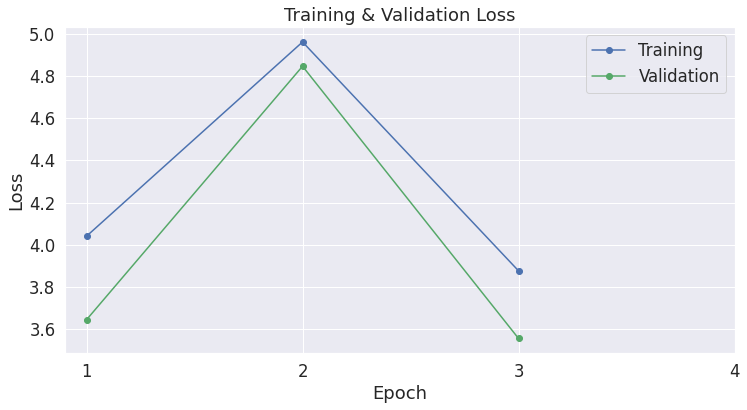

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_gpt_234/'
output_dir = os.path.join(root_folder, "./model_save_gpt_234/")

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/drive/My Drive/cs182_project/./model_save/


('/content/drive/My Drive/cs182_project/./model_save/tokenizer_config.json',
 '/content/drive/My Drive/cs182_project/./model_save/special_tokens_map.json',
 '/content/drive/My Drive/cs182_project/./model_save/vocab.json',
 '/content/drive/My Drive/cs182_project/./model_save/merges.txt',
 '/content/drive/My Drive/cs182_project/./model_save/added_tokens.json')

In [ ]:
config2 = GPT2Config.from_pretrained(output_dir)

In [ ]:
model2 = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer2 = GPT2Tokenizer.from_pretrained(output_dir)

In [ ]:
!ls -l --block-size=K /content/drive/My Drive/cs182_project/./model_save/

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/cs182_project/./model_save/': No such file or directory


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Aug 27 13:16 ./model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [ ]:
model2.eval()

prompt = "<|startoftext|> OMG I absolutely loved"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)
model2 = model2.to(device)

print(generated)

sample_outputs = model2.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 43821,   314,  5543,  6151]], device='cuda:0')
0:  OMG I absolutely loved this place. It's small but has a cute atmosphere and really good lighting.  It's definitely not a dive bar.  I got a groupon of 8 and it wasn't much special.  The bartender was super nice and attentive.  This spot is a hidden gem. My food is great. I will be coming back


1:  OMG I absolutely loved my experience at this studio, I am so grateful I did! First of all, the studio is a perfect place to get my daughters and moms baby shower cleaned! They have a huge selection of products including sheets, floor, bath, and wall outlets! They are very clean and have a wide variety of colors, and I highly recommend the old school to your needs and even children. It is a huge plus fun place for a quick workout. They love going! The children when you sit-they are always have a good


2:  OMG I absolutely loved this place. My friend and I went to the first place and it was a nice, comfortable atmosphere. We g

These aren't bad at all!
